# Explore here

It's recommended to use this notebook for exploration purposes.

In [1]:
#TODO 1: Install and import dependancies
import os
from bs4 import BeautifulSoup
import requests
import time
import pandas as pd
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
import io

#TODO 2: Download HTML
url = "https://en.wikipedia.org/wiki/List_of_most-streamed_songs_on_Spotify"

try:
    response = requests.get(url)
except Exception as e:
    print(e)
    response = None

#TODO 3: Transform the HTML
if response:
    html = io.StringIO(response.text)

    #TODO 4: Process the DataFrame
    df = pd.read_html(html)[0]
    df.columns = [col.strip() for col in df.columns]
    df.columns = ["Rank", "Song", "Artist", "Streams", "ReleaseDate", "Reference"]
    
    df = df.copy()

    df['Song'] = df['Song'].str.replace(r"\[.*?\]", repl="", regex=True)
    df['Artist'] = df['Artist'].str.replace(r"\[.*?\]", repl="", regex=True)

    # Keep only numeric values for Streams
    df = df[df['Streams'].astype(str).str.contains(r"^\d+(?:\.\d+)?$", na=False)].copy()

    df['Streams'] = df['Streams'].astype(float)
    df['ReleaseDate'] = pd.to_datetime(df['ReleaseDate'], errors="coerce")

    print(df.head())

#TODO 5: Store Data in SQLite
try:
    conn = sqlite3.connect("spotify_data.db")
    cursor = conn.cursor()

    # Drop table if exists to avoid any conflict
    cursor.execute("DROP TABLE IF EXISTS top_streamed_songs")

    # Create table
    cursor.execute("""
            CREATE TABLE IF NOT EXISTS top_streamed_songs (
                Rank INTEGER,
                Song TEXT,
                Artist TEXT,
                Streams REAL,
                ReleaseDate TEXT
            )
    """)

    for idx, row in df.iterrows():
        cursor.execute("""
            INSERT INTO top_streamed_songs (Rank, Song, Artist, Streams, ReleaseDate)
            VALUES (?, ?, ?, ?, ?)                   
            """, (
                int(row['Rank']),
                row['Song'].strip(),
                row['Artist'],
                row['Streams'],
                row['ReleaseDate'].strftime('%Y-%m-%d') if pd.notnull(row['ReleaseDate']) else None
    ))
        
    conn.commit()

except Exception as e:
    print(f"Failed to Store Data in SQL: {e}")

conn.close()

  Rank                 Song                    Artist  Streams ReleaseDate  \
0    1    "Blinding Lights"                The Weeknd    4.792  2019-11-29   
1    2       "Shape of You"                Ed Sheeran    4.310  2017-01-06   
2    3  "Someone You Loved"             Lewis Capaldi    3.865  2018-11-08   
3    4            "Starboy"  The Weeknd and Daft Punk    3.838  2016-09-21   
4    5          "As It Was"              Harry Styles    3.832  2022-04-01   

  Reference  
0       [2]  
1       [3]  
2       [4]  
3       [5]  
4       [6]  


/tmp/ipykernel_634/1670443939.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=data, y='Song', x='Streams', palette='coolwarm')


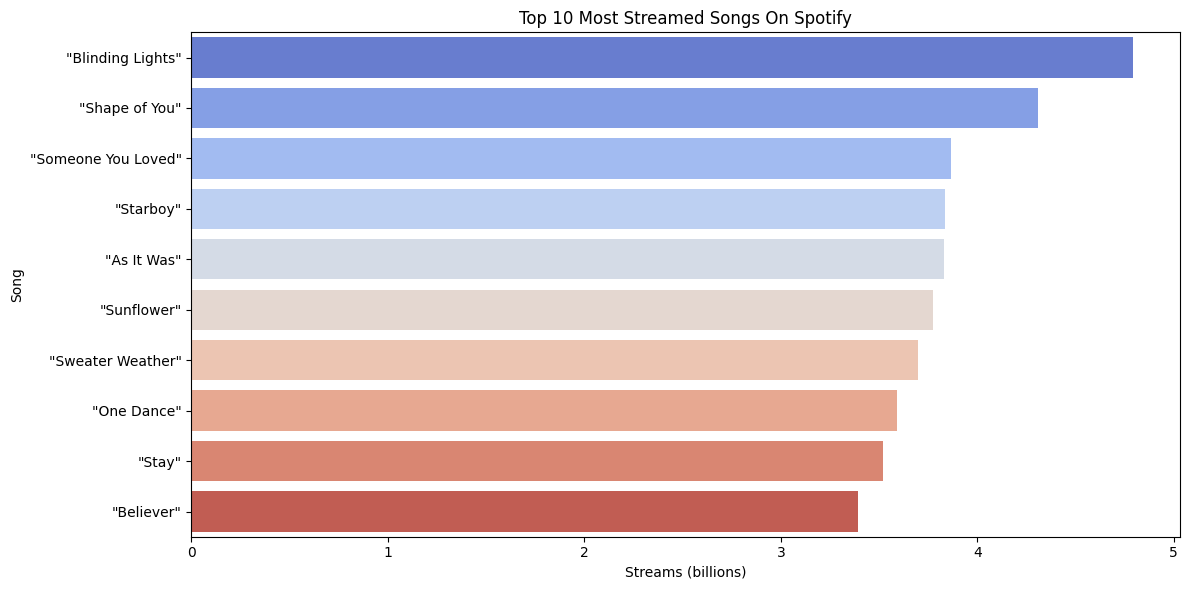

In [2]:
#TODO 6: Visualize Data #1 -Top Streamed Songs-
data = df.sort_values(by='Streams', ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(data=data, y='Song', x='Streams', palette='coolwarm')
plt.title("Top 10 Most Streamed Songs On Spotify")
plt.ylabel("Song")
plt.xlabel("Streams (billions)")
plt.tight_layout()
plt.show()

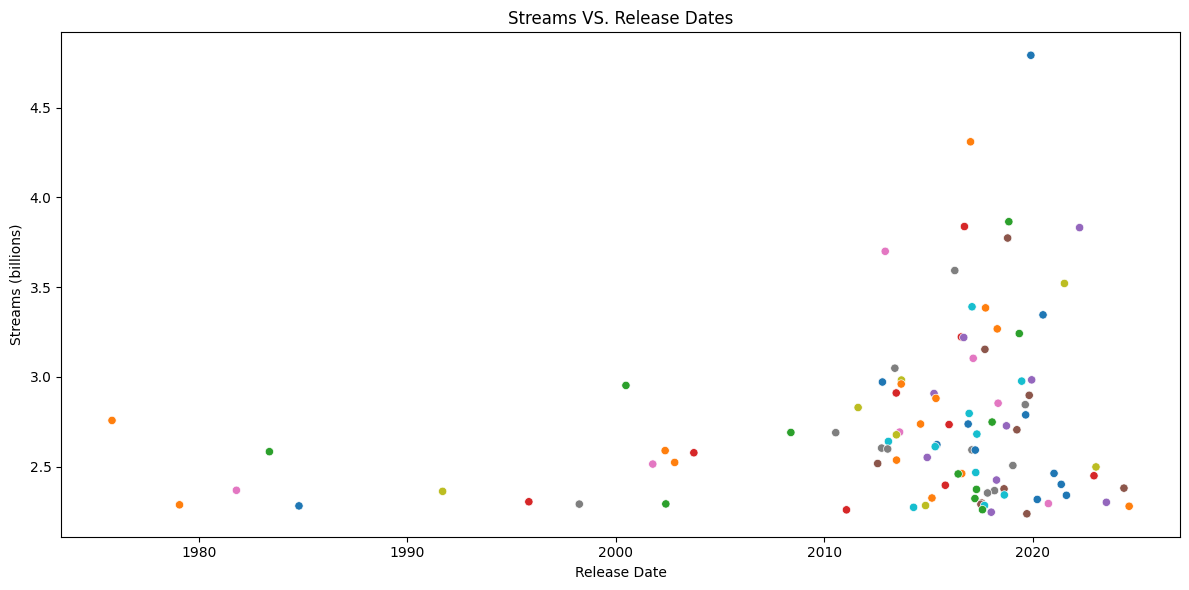

In [3]:
#TODO 6: Visualize Data #2 -Streams Over Release Dates-
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df, x="ReleaseDate", y="Streams", hue="Artist", legend=False, palette="tab10")
plt.title("Streams VS. Release Dates")
plt.ylabel("Streams (billions)")
plt.xlabel("Release Date")
plt.tight_layout()
plt.show()

/tmp/ipykernel_634/3666545356.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=filtered_df, x='Artist', y='Streams', palette='Set2')


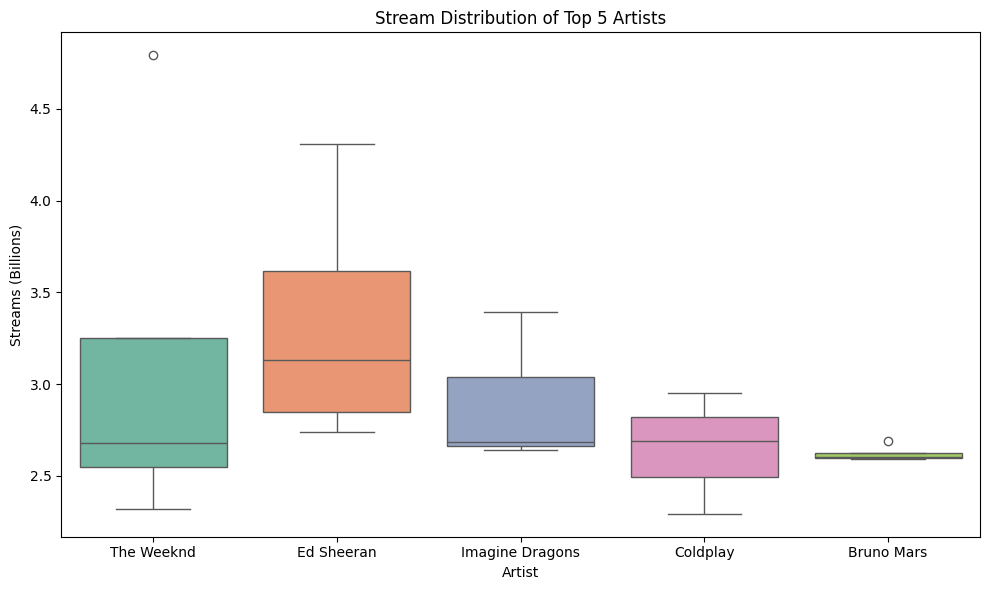

In [4]:
#TODO 6: Visualize Data #3 -Streams Distribution by Artist-
top_artists = df['Artist'].value_counts().head(5).index
filtered_df = df[df['Artist'].isin(top_artists)]

plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered_df, x='Artist', y='Streams', palette='Set2')
plt.title('Stream Distribution of Top 5 Artists')
plt.xlabel('Artist')
plt.ylabel('Streams (Billions)')
plt.tight_layout()
plt.show()